# Descripción del proyecto 

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Descripción de datos

Los datos se almacenan en el archivo /taxi.csv.

El número de pedidos está en la columna num_orders.

## Inicialización

In [89]:
#importemos las librerías que vamos a necesitar 
import pandas as pd 
import numpy as np 
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import pacf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors

## Carga de datos 

In [2]:
#importemos el dataset 
data = pd.read_csv('./taxi.csv')

#   Análisis y reparación de datos 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
data.sample(10)

,datetime,num_orders
23203,2018-08-09 03:10:00,13
23233,2018-08-09 08:10:00,19
15262,2018-06-14 23:40:00,20
19698,2018-07-15 19:00:00,9
21128,2018-07-25 17:20:00,21
7535,2018-04-22 07:50:00,3
5152,2018-04-05 18:40:00,8
5367,2018-04-07 06:30:00,5
24202,2018-08-16 01:40:00,20
8495,2018-04-28 23:50:00,16


In [6]:
print(data['datetime'].min())
print(data['datetime'].max())

2018-03-01 00:00:00
2018-08-31 23:50:00


<Axes: >

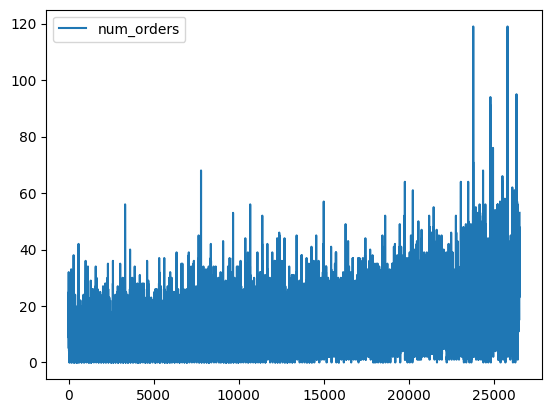

In [7]:
data.plot()

No hay valores nulos, el tipo de datos de la columna datetime es object por lo que hay que cambiarlo a datetime64. Todo los valores son del 2018. 

In [8]:
#Cambiemos los tipos de datos de la columna datetime de object a datetime64
data['datetime'] = data['datetime'].astype('datetime64[ns]')


In [9]:
#Validemos
data.info()
print(data.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
                 datetime  num_orders
239   2018-03-02 15:50:00          18
2770  2018-03-20 05:40:00           0
570   2018-03-04 23:00:00           6
9149  2018-05-03 12:50:00           5
17326 2018-06-29 07:40:00           5


In [10]:
#Fijemos la columna datetime como nuestro index 
data = data.set_index('datetime')
data = data.sort_index()
print(data.index.is_monotonic_increasing)
print(data.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [11]:
data.sample(3)

,num_orders
datetime,
2018-05-21 15:00:00,5
2018-04-02 04:50:00,5
2018-07-24 07:40:00,11


In [12]:
#Hagamos un resample para intervalos de 1 día. 
data_hr = data.resample('1h').sum()
data_hr

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


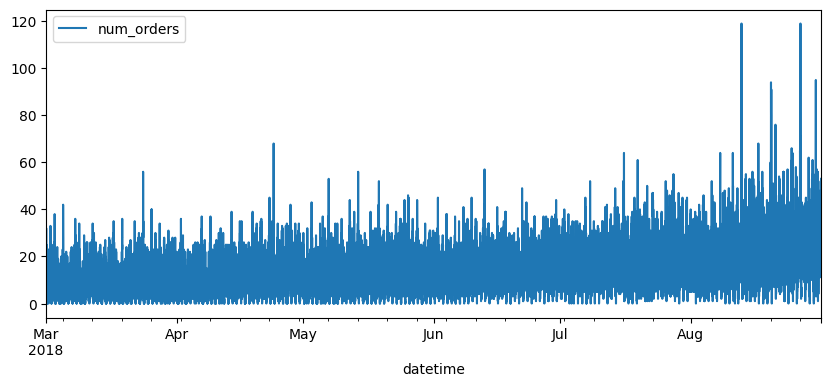

In [13]:
#Visualicemos la distribución de nuestros datos puros
data.plot(
    figsize=[10,4]
)

plt.show()

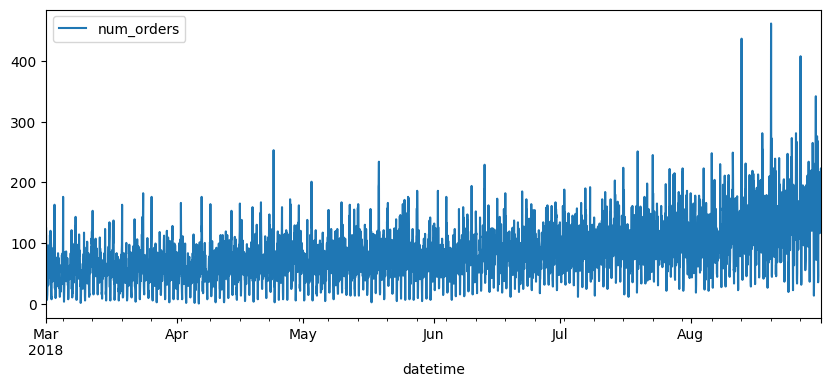

In [14]:
#Visualicemos la distribución de nuestros datos agrupados por hora
data_hr.plot(
    figsize=[10,4]
)

plt.show()

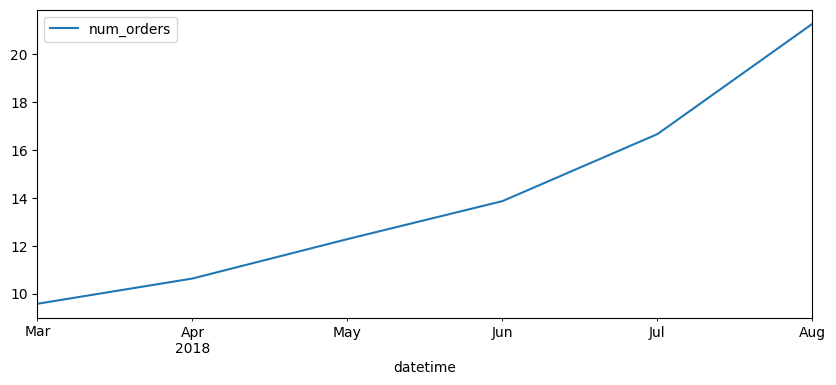

In [15]:
data_mes = data.resample('1ME').mean()
data_day = data.resample('1D').mean()
#veamos la distribución de los datos por mes 
data_mes.plot(
    figsize=[10,4]
)

plt.show()

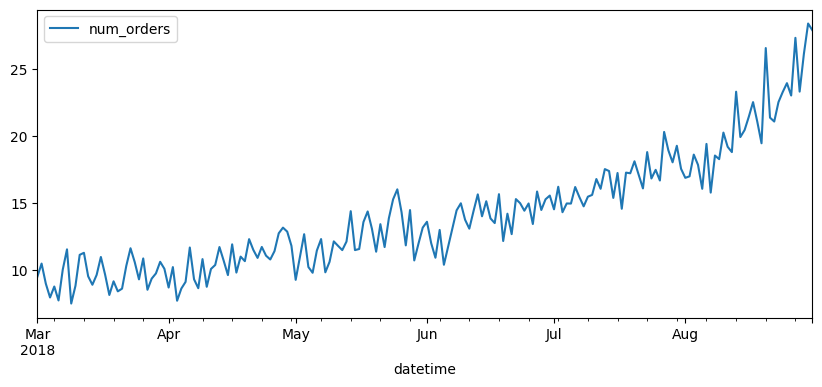

In [16]:
#Distribución de los datos por día
data_day.plot(
    figsize=[10,4]
)

plt.show()

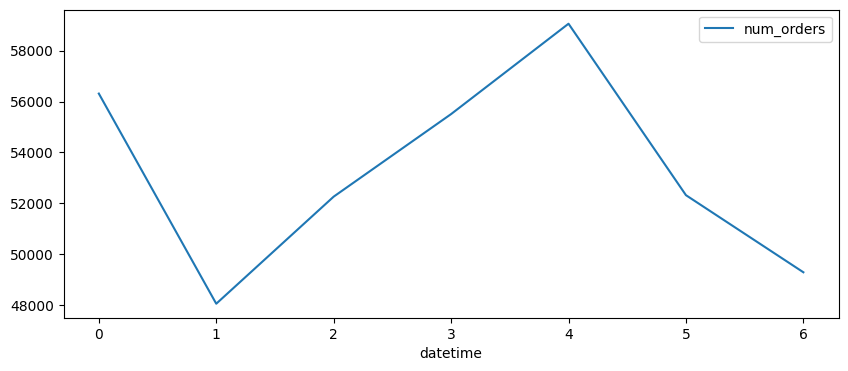

In [17]:
#Distribución de los datos por día de la semana
data_day_week = data.groupby(data.index.dayofweek).sum()
data_day_week.plot(
    figsize=[10,4]
)

plt.show()

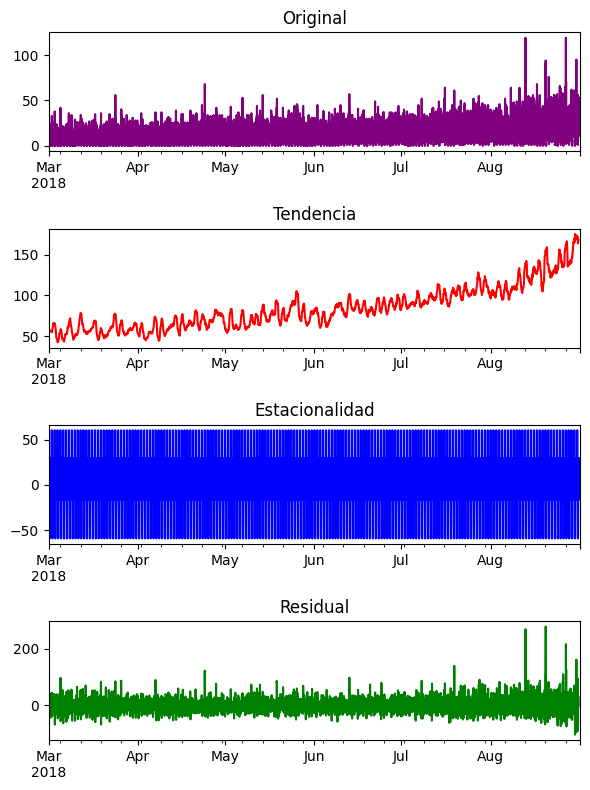

In [18]:
#Descomponemos la serie para ver la tendencia y estacionalidad 
data_decomposed = seasonal_decompose(data_hr)

plt.figure(figsize=(6,8))
plt.subplot(411)
data['num_orders'].plot(ax= plt.gca(), color='purple')
plt.title('Original')
plt.xlabel('')
plt.subplot(412)
data_decomposed.trend.plot(ax = plt.gca(), color='red')
plt.title('Tendencia')
plt.xlabel('')
plt.subplot(413)
data_decomposed.seasonal.plot(ax= plt.gca(), color='blue')
plt.title('Estacionalidad')
plt.xlabel('')
plt.subplot(414)
data_decomposed.resid.plot(ax= plt.gca(), color='green')
plt.title('Residual')
plt.xlabel('')

plt.tight_layout()


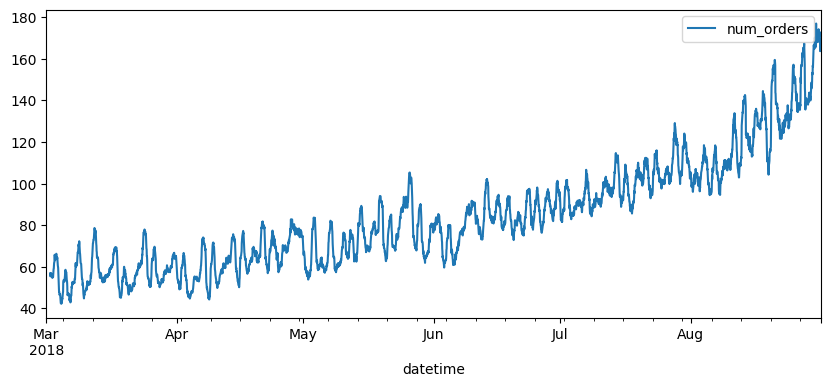

In [19]:
#Veamos si la serie es estacionaria 
med_mov_hr = data_hr.rolling(24).mean()
med_mov_hr.plot(
    figsize=[10,4]
)

plt.show()

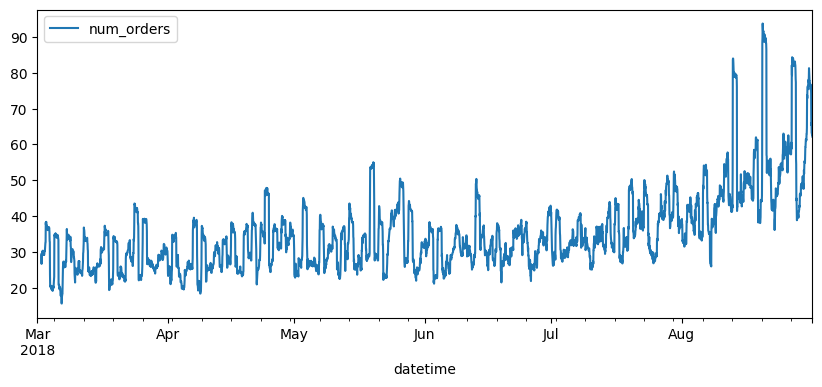

In [20]:
#Ver si la series es estacionaria a nivel de variabilidad
desv_std_hr = data_hr.rolling(24).std()
desv_std_hr.plot(
    figsize=[10,4]
)

plt.show()

Por los gráficos podríamos decir que nuestra serie temporal no es estacionaria ya que la medía y la desviación estandar cambia. Pero vamos a validarlo con una prueba de hipotesis Dickey - Fuller

#### Prueba hipotesis Dickey - Fuller 

H nula: La serie temporal NO es estacionaria (tiene raíz unitaria)

H alternativa: La serie temporal SI es estacionaria 

In [21]:
p_value = adfuller(data_hr)[1]

print(f"El valor p es:{p_value: .2%}")

El valor p es: 2.89%


Ahora puedo concluir que la serie NO es estacionaria. 

#### Conversión a seríe estacionaria

In [22]:
#Hagamos una copia de nuestro dt y calculemos la diferencia
new_data = data_hr.copy()
new_data['dif'] = new_data['num_orders'] - new_data['num_orders'].shift(fill_value=0)
new_data.head(10)

,num_orders,dif
datetime,,
2018-03-01 00:00:00,124,124
2018-03-01 01:00:00,85,-39
2018-03-01 02:00:00,71,-14
2018-03-01 03:00:00,66,-5
2018-03-01 04:00:00,43,-23
2018-03-01 05:00:00,6,-37
2018-03-01 06:00:00,12,6
2018-03-01 07:00:00,15,3
2018-03-01 08:00:00,34,19


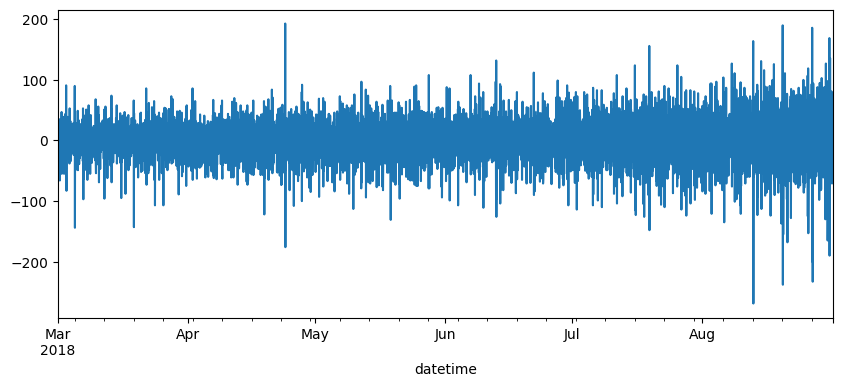

In [23]:
#visualicemos como queda 
new_data['dif'].plot(
    figsize=[10,4]
)

plt.show()

In [24]:
#validemos con una prueba dickey- fuller
p_value = adfuller(new_data['dif'])[1]

print(f"El valor p es:{p_value: .2%}")

El valor p es: 0.00%


Ya tenemos nuestra serie estacionaria ( la diferencia)

#### Autocorrelación 

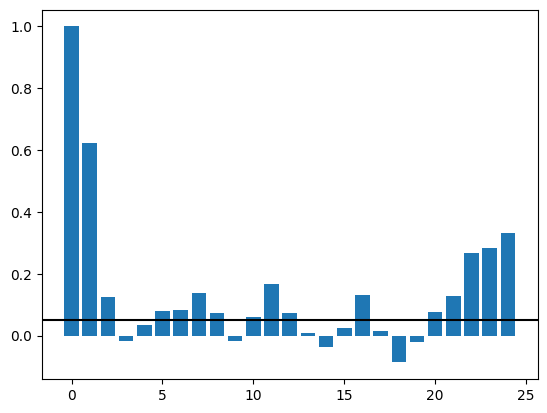

In [25]:
#veamos la autocorrelación de la serie normal
ls = data_hr.copy()

acp1 = pacf(ls, nlags=24)

plt.bar(
    x = range(25),
    height = acp1
)

plt.axhline(y = 0.05, color = 'black')
plt.show()

In [26]:
new_data = new_data.drop(columns=['num_orders'])

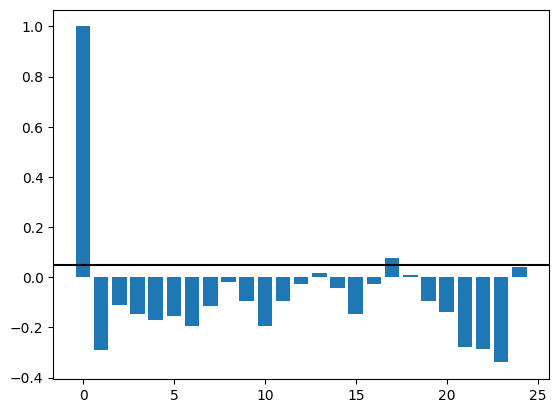

In [27]:
#Veamos la autorelación de la diferencia en la serie (estacionaria)
acp = pacf(new_data, nlags=24)

plt.bar(
    x = range(25),
    height = acp
)

plt.axhline(y = 0.05, color = 'black')
plt.show()


# Ingenieria de datos 

In [28]:
#Vamos a adicionar nuestros datos 

data_hr['day'] = data_hr.index.day
data_hr['month'] = data_hr.index.month
data_hr['day_of_week'] = data_hr.index.dayofweek

data_hr.head(10)

,num_orders,day,month,day_of_week
datetime,,,,
2018-03-01 00:00:00,124,1,3,3
2018-03-01 01:00:00,85,1,3,3
2018-03-01 02:00:00,71,1,3,3
2018-03-01 03:00:00,66,1,3,3
2018-03-01 04:00:00,43,1,3,3
2018-03-01 05:00:00,6,1,3,3
2018-03-01 06:00:00,12,1,3,3
2018-03-01 07:00:00,15,1,3,3
2018-03-01 08:00:00,34,1,3,3


In [47]:
#Hacemos una función para adicionar lags a los datos y tambien adicionar la media movil a nuestro dataset

def lag_med(data, value):
    for l in range(value): 
        data['lag_{}'.format(l+1)] = data['num_orders'].shift(l+1)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(value).mean()
    
    return data.dropna(inplace=True)

In [48]:
#Para poder probar distintos lags, Vamos a probar con 6 y con 24 lags respectivamente 
#Creamos nuestros nuevos datasets 
hour_data_s6 = data_hr.copy()
hour_data_s24 = data_hr.copy()

#Corremos nuestras respectivas funciones 
lag_med(hour_data_s6,6)
lag_med(hour_data_s24,24)


In [49]:
print(hour_data_s6.head(10))

                     num_orders  day  month  day_of_week  lag_1  lag_2  lag_3  \
datetime                                                                        
2018-03-01 06:00:00          12    1      3            3    6.0   43.0   66.0   
2018-03-01 07:00:00          15    1      3            3   12.0    6.0   43.0   
2018-03-01 08:00:00          34    1      3            3   15.0   12.0    6.0   
2018-03-01 09:00:00          69    1      3            3   34.0   15.0   12.0   
2018-03-01 10:00:00          64    1      3            3   69.0   34.0   15.0   
2018-03-01 11:00:00          96    1      3            3   64.0   69.0   34.0   
2018-03-01 12:00:00          30    1      3            3   96.0   64.0   69.0   
2018-03-01 13:00:00          32    1      3            3   30.0   96.0   64.0   
2018-03-01 14:00:00          48    1      3            3   32.0   30.0   96.0   
2018-03-01 15:00:00          66    1      3            3   48.0   32.0   30.0   

                     lag_4 

In [50]:
print(hour_data_s24.head())

                     num_orders  day  month  day_of_week  lag_1  lag_2  lag_3  \
datetime                                                                        
2018-03-02 00:00:00          90    2      3            4   58.0  113.0   66.0   
2018-03-02 01:00:00         120    2      3            4   90.0   58.0  113.0   
2018-03-02 02:00:00          75    2      3            4  120.0   90.0   58.0   
2018-03-02 03:00:00          64    2      3            4   75.0  120.0   90.0   
2018-03-02 04:00:00          20    2      3            4   64.0   75.0  120.0   

                     lag_4  lag_5  lag_6  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-02 00:00:00   61.0   45.0   73.0  ...    34.0    15.0    12.0     6.0   
2018-03-02 01:00:00   66.0   61.0   45.0  ...    69.0    34.0    15.0    12.0   
2018-03-02 02:00:00  113.0   66.0   61.0  ...    64.0    69.0    34.0    15.0   
2018-03-02 03:00:00   58.0 

#### Separemos nuestros datos 

In [51]:
#Separamos atributos y target de los datos para nuestros 2 data sets (con lag6 y lag24)
x6 = hour_data_s6.drop(columns='num_orders')
y6 = hour_data_s6['num_orders']

x24 = hour_data_s24.drop(columns='num_orders')
y24 = hour_data_s24['num_orders']


In [56]:
#Separemos los datos para prueba y validación


x6_train, x6_test, y6_train, y6_test = train_test_split(x6, y6, test_size=0.1, shuffle=False, random_state=123)

x24_train, x24_test, y24_train, y24_test = train_test_split(x24, y24, test_size=0.1, shuffle=False, random_state=123)

# Modelaje 

### Regresión lineal 

In [57]:
#Comencemos con el lag6 
model_6 = LinearRegression()
model_6.fit(x6_train,y6_train)

s6_pred = model_6.predict(x6_test)
rmse_s6 = np.sqrt(mean_squared_error(y6_test,s6_pred))

print(rmse_s6)

53.201657382476334


In [59]:
model_24 = LinearRegression()
model_24.fit(x24_train,y24_train)

s24_pred = model_24.predict(x24_test)
rmse_s24 = np.sqrt(mean_squared_error(y24_test,s24_pred))

print(rmse_s24)

45.542447455062074


In [105]:
s24_pred

array([117.69772699, 101.08958457, 114.2420824 ,  88.53811966,
        74.8237329 ,  95.3796487 , 123.76264107, 147.415319  ,
       172.70601396, 217.28178523, 280.78384775, 147.3641895 ,
       142.92989375, 100.16276557,  55.01307652,  49.01830746,
        98.45900656, 123.76546455, 132.0339025 , 139.1691857 ,
       111.59169324, 114.70992851, 105.11445892, 132.05853871,
       125.61422923, 129.46203191, 104.43888539,  99.99904294,
        97.42494365, 116.82685994, 112.53038762, 123.52400003,
       156.04690015, 198.94678599, 129.62304872, 153.83092319,
       115.37952488,  68.77011172,  68.51003776,  79.98543071,
        74.49996795, 111.02837238, 146.00375471, 151.21128215,
       121.54889973,  83.30580757,  77.95359729, 112.56528134,
       127.48168764, 154.95686504, 117.82284951,  91.16778763,
        90.86248939, 129.62809446, 146.68744813, 170.43059423,
       160.69991126, 125.57011172, 157.75076078, 145.20631019,
       143.6486263 , 111.95771931,  58.67327372,  44.02

Podemos observar que utilizando una ventana más amplia ( 24 lags) tenemos mejores resultados. 

### Arból de decision

In [83]:
tree_s6_model = DecisionTreeRegressor(random_state=123, max_depth=5)
tree_s6_model.fit(x6_train,y6_train)

s6_tree_pred = tree_s6_model.predict(x6_test)
rmse_tree_s6 = np.sqrt(mean_squared_error(y6_test, s6_tree_pred))

print(rmse_tree_s6)

63.58215126973542


In [87]:
best_depth = 0
best_rmse = 1000

for depth in range(1,100):
    de_tree=DecisionTreeRegressor(random_state=123,max_depth=depth)
    de_tree.fit(x24_train,y24_train)
    pred_dec = de_tree.predict(x24_test)
    rmse_dee = np.sqrt(mean_squared_error(y24_test, pred_dec))
    print(f'max_depth:{depth} , rmse: {rmse_dee}')
    if rmse_dee < best_rmse:
        best_depth = depth
        best_rmse = rmse_dee
    
print(f"RMSE del mejor modelo en el conjunto de validación (max_depth = {best_depth}): {best_rmse}")

max_depth:1 , rmse: 71.71397179045253
max_depth:2 , rmse: 62.88986261693565
max_depth:3 , rmse: 56.40077266633896
max_depth:4 , rmse: 55.19651104606534
max_depth:5 , rmse: 53.1705872662485
max_depth:6 , rmse: 60.755854231736684
max_depth:7 , rmse: 62.04554578266079
max_depth:8 , rmse: 62.248910885456475
max_depth:9 , rmse: 60.78336519427246
max_depth:10 , rmse: 60.00119733674004
max_depth:11 , rmse: 64.45134220726003
max_depth:12 , rmse: 66.31529250891317
max_depth:13 , rmse: 63.136244247061555
max_depth:14 , rmse: 59.31294257218988
max_depth:15 , rmse: 65.26771505034868
max_depth:16 , rmse: 65.10746707347077
max_depth:17 , rmse: 58.4079165140354
max_depth:18 , rmse: 55.790139750696774
max_depth:19 , rmse: 64.8310728503444
max_depth:20 , rmse: 58.19544050399949
max_depth:21 , rmse: 58.92352637298003
max_depth:22 , rmse: 62.11279908848144
max_depth:23 , rmse: 62.96781397341748
max_depth:24 , rmse: 58.984035783190755
max_depth:25 , rmse: 65.08531114831308
max_depth:26 , rmse: 58.71104124

In [85]:
tree_s24_model = DecisionTreeRegressor(random_state=123, max_depth=5)
tree_s24_model.fit(x24_train,y24_train)

s26_tree_pred = tree_s24_model.predict(x24_test)
rmse_tree_s24 = np.sqrt(mean_squared_error(y24_test,s26_tree_pred))

print(rmse_tree_s24)

53.1705872662485


In [104]:
s26_tree_pred

array([123.63917526, 107.60137457, 107.60137457,  85.136     ,
        90.20882353,  90.20882353, 107.60137457, 123.63917526,
       146.64130435, 123.63917526, 123.63917526, 123.63917526,
       123.63917526, 107.60137457,  61.66029724,  49.20430108,
        87.91954023,  90.20882353, 123.63917526, 123.63917526,
       107.60137457, 107.60137457,  87.91954023, 123.63917526,
       123.63917526, 123.63917526,  85.136     , 118.4047619 ,
        85.136     ,  90.20882353, 107.60137457,  90.20882353,
       146.64130435, 123.63917526, 118.4047619 , 123.63917526,
       123.63917526,  60.64864865,  60.64864865,  77.91836735,
        87.91954023, 113.23188406, 123.63917526, 123.63917526,
       107.60137457,  78.13567839,  90.20882353, 107.60137457,
       107.60137457, 123.63917526, 107.60137457, 118.4047619 ,
        85.136     , 107.60137457, 107.60137457, 146.64130435,
       146.64130435, 107.60137457, 123.63917526, 107.60137457,
       123.63917526, 107.60137457,  48.54545455,  24.49

Para el caso del arbol decisiones no logramos el cometido del RMSE menor de 48 incluso probando disintas configuraciones de profundidad. 

### Bosque Aleatorio 

In [ ]:
#Encontremos la mejor configuración para para lag6
bst_err = 1000
bst_est = 0
bst_depth = 0 

#Queremos encontrar los mejores hiperparametros, lo hacemos con nuestros datos de prueba 
for e in range(1,50,10):
    for d in range(1,30,5):
        rand_for= RandomForestRegressor(random_state=123, max_depth=d, n_estimators=e)
        rand_for.fit(x6_train,y6_train)
        rand_for_pred = rand_for.predict(x6_test) 
        rmse_rand_for = np.sqrt(mean_squared_error(y6_test, rand_for_pred))
        print(F'n_estimator: {e} ,Profundidad {d}, RMSE: {rmse_rand_for}')
        if rmse_rand_for < bst_err:
            bst_err = rmse_rand_for
            bst_est = e
            bst_depth = d
        
print(f"RMSE del mejor modelo en el conjunto de validación (max_depth = {bst_depth}): {bst_err}, n_estimador: {bst_est}")
    

n_estimator: 1 ,Profundidad 1, RMSE: 76.74592556455313
n_estimator: 1 ,Profundidad 6, RMSE: 68.76390314895332
n_estimator: 1 ,Profundidad 11, RMSE: 68.61288586396266
n_estimator: 1 ,Profundidad 16, RMSE: 69.81872843853033
n_estimator: 1 ,Profundidad 21, RMSE: 69.53471864835342
n_estimator: 1 ,Profundidad 26, RMSE: 68.40961396943204
n_estimator: 11 ,Profundidad 1, RMSE: 73.83683731630593
n_estimator: 11 ,Profundidad 6, RMSE: 62.77317540942438
n_estimator: 11 ,Profundidad 11, RMSE: 60.33348302308314
n_estimator: 11 ,Profundidad 16, RMSE: 61.01977442778294
n_estimator: 11 ,Profundidad 21, RMSE: 59.706643617822614
n_estimator: 11 ,Profundidad 26, RMSE: 61.81444278529497
n_estimator: 21 ,Profundidad 1, RMSE: 74.21800625207199
n_estimator: 21 ,Profundidad 6, RMSE: 62.003630509321894
n_estimator: 21 ,Profundidad 11, RMSE: 59.563377199190704
n_estimator: 21 ,Profundidad 16, RMSE: 60.198481732437514
n_estimator: 21 ,Profundidad 21, RMSE: 59.57111977522498
n_estimator: 21 ,Profundidad 26, RMSE: 

In [97]:
rand_for= RandomForestRegressor(random_state=123, max_depth=11, n_estimators=31)
rand_for.fit(x6_train,y6_train)
rand_for_pred = rand_for.predict(x6_test) 
rmse_rand_for = np.sqrt(mean_squared_error(y6_test, rand_for_pred))

print(rmse_rand_for)

58.66109771230795


In [98]:
#Encontremos la mejor configuración para para lag24
best_err = 1000
best_est = 0
bs_depth = 0 

#Queremos encontrar los mejores hiperparametros, lo hacemos con nuestros datos de prueba 
for e in range(1,50,10):
    for d in range(1,30,5):
        rand_for= RandomForestRegressor(random_state=123, max_depth=d, n_estimators=e)
        rand_for.fit(x24_train,y24_train)
        rand_for_pred = rand_for.predict(x24_test) 
        rmse_rand_for = np.sqrt(mean_squared_error(y24_test, rand_for_pred))
        print(F'n_estimator: {e} ,Profundidad {d}, RMSE: {rmse_rand_for}')
        if rmse_rand_for < bst_err:
            bst_err = rmse_rand_for
            bst_est = e
            bs_depth = d
        
print(f"RMSE del mejor modelo en el conjunto de validación (max_depth = {bst_depth}): {bst_err}, n_estimador: {bst_est}")

n_estimator: 1 ,Profundidad 1, RMSE: 71.53310582031567
n_estimator: 1 ,Profundidad 6, RMSE: 58.14400731796396
n_estimator: 1 ,Profundidad 11, RMSE: 70.4437444067849
n_estimator: 1 ,Profundidad 16, RMSE: 69.50305106717876
n_estimator: 1 ,Profundidad 21, RMSE: 73.21951614832308
n_estimator: 1 ,Profundidad 26, RMSE: 72.12294004444281
n_estimator: 11 ,Profundidad 1, RMSE: 70.78292267963383
n_estimator: 11 ,Profundidad 6, RMSE: 48.4892749951706
n_estimator: 11 ,Profundidad 11, RMSE: 46.44337681873591
n_estimator: 11 ,Profundidad 16, RMSE: 46.65805575809164
n_estimator: 11 ,Profundidad 21, RMSE: 45.68256053721196
n_estimator: 11 ,Profundidad 26, RMSE: 46.4259148178926
n_estimator: 21 ,Profundidad 1, RMSE: 71.34421350517928
n_estimator: 21 ,Profundidad 6, RMSE: 47.400957442116656
n_estimator: 21 ,Profundidad 11, RMSE: 45.18105080950308
n_estimator: 21 ,Profundidad 16, RMSE: 44.99559056494442
n_estimator: 21 ,Profundidad 21, RMSE: 45.36794020025554
n_estimator: 21 ,Profundidad 26, RMSE: 45.109

In [103]:
rand_for_24= RandomForestRegressor(random_state=123, max_depth=16, n_estimators=31)
rand_for_24.fit(x24_train,y24_train)
rand_for_pred_24= rand_for_24.predict(x24_test) 
rmse_rand_for_24 = np.sqrt(mean_squared_error(y24_test, rand_for_pred_24))
print(rmse_rand_for_24)

44.029773967713666


In [106]:
rand_for_pred_24

array([149.77533085, 146.46774194, 105.76249209, 100.65922602,
       100.79609214, 119.78122922, 136.59925558, 149.37327189,
       161.40645161, 140.90322581, 150.84639017, 160.84427141,
       138.01617294, 105.20128448,  71.87096774,  50.08721625,
        82.5533033 , 116.17040973, 115.76910017, 134.68548387,
       109.01910231, 140.18858561,  88.26934771, 137.0163882 ,
       148.23742809, 148.        , 115.3233871 ,  96.46166562,
        99.8797596 , 109.85570937, 127.48289755, 120.60683829,
       141.24991511, 170.83870968, 156.72434018, 123.75969157,
       126.89189046,  66.14629032,  67.02741935,  61.48506571,
        80.97738932, 125.68100358, 125.55072156, 109.49544426,
       111.66660266, 105.0165217 ,  86.9271049 , 126.65143369,
       145.81263441, 133.85114978, 120.55684693, 120.49161581,
       115.40978296, 126.10682357, 137.06451613, 154.66451613,
       167.12563667, 146.12756598, 186.22580645, 169.4898263 ,
       151.06290323, 113.028463  ,  58.99291896,  51.70

Con el modelo de bosque aleatorio y las mejores configuraciones encontramos que con el lag24 tenemos un modelo que predice con un RMSE menor a 48.

# Conclusiones 

Tenemos un conjunto de datos que convertimos en seríe temporal y agrupamos por hora. Observamos su distribución para hora, día , mes y día de la semana y despues de calcular la media movil y la desviación estandar para la misma venta concluimos que nuestra serie no es estacionaria. 

Agregamos caracteristicas como el día, mes y día de la semana.

Probamos 2 distintos distintos periodos a observar(lags) para nuestros datos, considerando 6 horas y 24 horas. Modelamos 3 modelos: Regresión lineal, arbol de desiciones y bosque aleatorio. 

El modelo de regresión lineal fue mejor para el periodo de 24 hora, cumpliendo con la metrica de RMSE menor de 48. para el lag de 6 no se cumplío.

Para el modelo de árbol de decisiones probamos distintos parámetros pero no pudimos mejorarlo significativamente ni para el lag 6 ni para el lag 24. 

En cuanto al modelo de bosque aleatorio también probamos distintos parámetros y encontramos que para el periodo de 24 horas logramos un RMSE menor de 48 cumpliendo con la meta. Pero para el el lag de 6 horas no se cumplió. 